In [1]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from datetime import datetime
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
print(tf.__version__)

2.8.0


In [ ]:
analisi accuratezza modello. vedere slide, positive predictive value, negative predictive value, specificity and selectivity

matrice di confusione matrice 10x10 in percentuale quel numero è stato scelto come l'altro numero n volte 20 epoche



In [2]:
class CapsuleNetwork(tf.keras.Model):
    def __init__(self, no_of_conv_kernels, no_of_primary_capsules, primary_capsule_vector, no_of_secondary_capsules, secondary_capsule_vector, r):
        super(CapsuleNetwork, self).__init__()
        self.no_of_conv_kernels = no_of_conv_kernels
        self.no_of_primary_capsules = no_of_primary_capsules
        self.primary_capsule_vector = primary_capsule_vector
        self.no_of_secondary_capsules = no_of_secondary_capsules
        self.secondary_capsule_vector = secondary_capsule_vector
        self.r = r
        
        with tf.name_scope("Variables") as scope:
            # creates convolutional layer with 256 9x9 kernels, stride 1, activation relu ( max(n,0) )
            # the model learns 256 9x9 filters and 256 biases
            # applies the filter then adds the bias and applies relu
                                                      # 256
            self.convolution = tf.keras.layers.Conv2D(self.no_of_conv_kernels, [9,9], strides=[1,1], name='ConvolutionLayer', activation='relu')
            
            # learns 32 * 8 (= 252) filters with kernel 9x9 and stride 2
                                                         #   32                       * 8
            self.primary_capsule = tf.keras.layers.Conv2D(self.no_of_primary_capsules * self.primary_capsule_vector, [9,9], strides=[2,2], name="PrimaryCapsule")
            
            # creates trainable tensor: shape=[1, 1152, 10, 16, 8])
            # there are 32 capsule each of those has 36 (6*6) 8D vector (6*6*32 = 1152 => 8D Vectors)
                                                                          #      10                             16                                 8
            self.w = tf.Variable(tf.random_normal_initializer()(shape=[1, 1152, self.no_of_secondary_capsules, self.secondary_capsule_vector, self.primary_capsule_vector]), dtype=tf.float32, name="PoseEstimation", trainable=True)
            
            # fully connected layers for image reconstruction
            self.dense_1 = tf.keras.layers.Dense(units = 512, activation='relu')
            self.dense_2 = tf.keras.layers.Dense(units = 1024, activation='relu')
            self.dense_3 = tf.keras.layers.Dense(units = 784, activation='sigmoid', dtype='float32')
        
    def build(self, input_shape):
        pass
    

    def save(self):
        #  save the current trained module
        self.save_weights('saved_model/weights/capsule_network_weights')
    
    def squash(self, s):
        with tf.name_scope("SquashFunction") as scope:
            s_norm = tf.norm(s, axis=-1, keepdims=True)
            return tf.square(s_norm)/(1 + tf.square(s_norm)) * s/(s_norm + epsilon)
    
    @tf.function
    def call(self, inputs):
        input_x, y = inputs
        # input_x.shape: (None, 28, 28, 1)
        # y.shape: (None, 10)
        
        x = self.convolution(input_x) #x.shape: (None, 20, 20, 256)
        x = self.primary_capsule(x) #x.shape: (None, 6, 6, 256) => 6*6*8*32 / 8 = 1152
        
        #there are 32 capsule with dimension 8, each of those has 36 (=6*6) 8D vector (36*32 = 1152 => 8D Vectors)
        
        with tf.name_scope("CapsuleFormation") as scope:
            #converting output from shape (None, 6, 6, 256) to shape (None, 1152, 8)
            # from 256 2D images to => 1152 8D vector
                                   # 32                        * 6          * 6            8     
            u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], self.primary_capsule_vector)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            
                                                  # w.shape: ( 1, 1152, 10, 16, 8 )
                                               # u.shape: ( None, 1152,  1,  8, 1 )
            u_hat = tf.matmul(self.w, u)   # u_hat.shape: ( None, 1152, 10, 16, 1 )
            u_hat = tf.squeeze(u_hat, [4])  # u_hat.shape: (None, 1152, 10, 16 )
        
        with tf.name_scope("DynamicRouting") as scope:
                                                       # 10                  
            b = tf.zeros((input_x.shape[0], 1152, self.no_of_secondary_capsules, 1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement
                
        with tf.name_scope("Masking") as scope:
            y = tf.expand_dims(y, axis=-1) # y.shape: (None, 10, 1)
            y = tf.expand_dims(y, axis=1) # y.shape: (None, 1, 10, 1)
            mask = tf.cast(y, dtype=tf.float32) # mask.shape: (None, 1, 10, 1)
            v_masked = tf.multiply(mask, v) # v_masked.shape: (None, 1, 10, 16)
            
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(v_masked, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) # v_.shape: (None, 160)
            reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)
        
        return v, reconstructed_image
    
    @tf.function
    def predict_capsule_output(self, inputs):
        x = self.convolution(inputs) # x.shape: (None, 20, 20, 256)
        x = self.primary_capsule(x) # x.shape: (None, 6, 6, 256)
        
        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], 8)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)

        
        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((inputs.shape[0], 1152, self.no_of_secondary_capsules, 1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement
        return v

    @tf.function
    def regenerate_image(self, inputs):
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(inputs, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) # v_.shape: (None, 160)
            reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)
        return reconstructed_image

In [3]:
def safe_norm(v, axis=-1, epsilon=1e-7):
    v_ = tf.reduce_sum(tf.square(v), axis = axis, keepdims=True)
    return tf.sqrt(v_ + epsilon)

def predict(model, x):
    pred = safe_norm(model.predict_capsule_output(x))
    pred = tf.squeeze(pred, [1])
    return np.argmax(pred, axis=1)[:,0]

def loss_function(v, reconstructed_image, y, y_image):
    prediction = safe_norm(v)
    prediction = tf.reshape(prediction, [-1, no_of_secondary_capsules])
    
    left_margin = tf.square(tf.maximum(0.0, m_plus - prediction))
    right_margin = tf.square(tf.maximum(0.0, prediction - m_minus))
    
    l = tf.add(y * left_margin, lambda_ * (1.0 - y) * right_margin)
    
    margin_loss = tf.reduce_mean(tf.reduce_sum(l, axis=-1))
    
    y_image_flat = tf.reshape(y_image, [-1, 784])
    reconstruction_loss = tf.reduce_mean(tf.square(y_image_flat - reconstructed_image))
    
    loss = tf.add(margin_loss, alpha * reconstruction_loss)
    
    return loss

def train(x,y):
    y_one_hot = tf.one_hot(y, depth=10)
    with tf.GradientTape() as tape:
        v, reconstructed_image = model([x, y_one_hot])
        loss = loss_function(v, reconstructed_image, y_one_hot, x)
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss

def gerAccuracy():
    test_sum = 0

    for X_batch, y_batch in testing:
        test_sum += sum(predict(model, X_batch)==y_batch.numpy())

    print(test_sum/testing_dataset_size)

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

BATCH_SIZE = 64

############## Parameters Based on Paper
epsilon = 1e-7
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5
alpha = 0.0005
epochs = 10
no_of_secondary_capsules = 10

optimizer = tf.keras.optimizers.Adam()

params = {
    "no_of_conv_kernels": 256,
    "no_of_primary_capsules": 32,
    "no_of_secondary_capsules": 10,
    "primary_capsule_vector": 8,
    "secondary_capsule_vector": 16,
    "r":3,
}

###################################

checkpoint_path = './logs/model/capsule'

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")

logdir = './logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

scalar_logdir = './logs/scalars/%s' % stamp
file_writer = tf.summary.create_file_writer(scalar_logdir + "/metrics")

(X_train, y_train), (X_test , y_test)= tf.keras.datasets.mnist.load_data()

X_train = X_train / 255.0
X_train = tf.cast(X_train, dtype=tf.float32)
X_train = tf.expand_dims(X_train, axis=-1)

X_test = X_test / 255.0
X_test = tf.cast(X_test, dtype=tf.float32)
X_test = tf.expand_dims(X_test, axis=-1)

testing_dataset_size = X_test.shape[0]
training_dataset_size = X_train.shape[0]

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size=BATCH_SIZE)

testing = tf.data.Dataset.from_tensor_slices((X_test, y_test))
testing = testing.batch(batch_size=BATCH_SIZE)

tf.summary.trace_on(graph=True, profiler=True)

model = CapsuleNetwork(**params)
model.load_weights('saved_model/weights/capsule_network_weights')

_ = train(X_train[:int(BATCH_SIZE/2)],y_train[:int(BATCH_SIZE/2)])
with writer.as_default():
    tf.summary.trace_export(name="my_func_trace", step=0, profiler_outdir=logdir) 
    
tf.summary.trace_off()

model.summary()

Metal device set to: Apple M1
Found GPU at: /device:GPU:0


2022-06-01 09:21:12.492987: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-01 09:21:12.493200: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-01 09:21:12.498016: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-01 09:21:12.498031: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Instructions for updating:
use `tf.profiler.experimental.start` instead.


2022-06-01 09:21:13.000210: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-06-01 09:21:13.000219: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-06-01 09:21:13.526366: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-01 09:21:13.527112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 09:21:14.307660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Model: "capsule_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ConvolutionLayer (Conv2D)   multiple                  20992     
                                                                 
 PrimaryCapsule (Conv2D)     multiple                  5308672   
                                                                 
 dense (Dense)               multiple                  82432     
                                                                 
 dense_1 (Dense)             multiple                  525312    
                                                                 
 dense_2 (Dense)             multiple            

2022-06-01 09:21:16.715090: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-06-01 09:21:16.720028: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.


In [5]:
def show_prediction(image, label):
    rx = tf.reshape(image, [1, 28, 28, 1])
    ry = tf.reshape(label, [1,] )
    p = predict(model, rx)[0]
    plt.figure()
    plt.xlabel("value: "+str(ry.numpy()[0])+" - prediction: "+str(p)) #label
    plt.imshow(rx[0])

In [6]:
def show_grid(x, dimx, dimy, title, size=20.):
    fig = plt.figure(figsize=(size, size))
    fig.suptitle(title, fontsize=16)
    grid = ImageGrid( fig, 111,nrows_ncols=(dimy, dimx),axes_pad=0.1, )
    a = []

    for i in range(dimx*dimy):
        j = x[:, :, i]
        a.append(j)

    for ax, im in zip(grid, a):
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.imshow(im, cmap="gray")

    fig.subplots_adjust(top=0.97) 
    plt.show()

In [7]:
def show_conv1_rfm(x, f, b, img):  # f.shape: (9, 9, 1, 256) b.shape: (256,)
    rx = np.array(tf.reshape( x[img], [1, 28, 28, 1])) # rx.shape: (1, 28, 28, 1)
    rx = tf.nn.conv2d(rx,f,strides=[1, 1],padding='VALID') # rx.shape: (1, 20, 20, 256)
    rx = tf.add(rx, b)
    rx = tf.nn.relu(rx).numpy()
    show_grid(rx[0], 16, 16, "Conv1 256 output")

In [8]:
def show_prim_caps_rfm(x, f, b, img): # x.shape: (64, 20, 20, 256) f.shape: (9, 9, 256, 256) b.shape: (256,)
    rx = np.array(tf.reshape( x[img], [1, 20, 20, 256])) # rx.shape: (1, 20, 20, 256)
    rx = tf.nn.conv2d(rx,f,strides=[2, 2],padding='VALID') # rx.shape: (1, 6, 6, 256)
    rx = tf.add(rx, b)
    show_grid(rx[0], 8, 32, "32 Primary Capsule 6x6x8 output", 40.) # there are 32 capsule each of one is 8D ( 8*32 = 256 )

In [9]:
def recostruction(model, x, y, img):
    
    show_prediction(x[img], y[img]) # show prediction
    
    #---------- CONV 1
    
    # filters
    f = model.layers[0].get_weights()[0] # f.shape: (9, 9, 1, 256)
    # biases
    b = model.layers[0].get_weights()[1] # b.shape: (256,)
    
    #### apply conv1
    # reshape input (x is a batch of images, we consider only one image at time)
    print(x.shape)
    # x.shape: (64, 28, 28, 1) ==> rx.shape(1, 28, 28, 1)
    rx = np.array(tf.reshape( x[img], [1, 28, 28, 1])) 
    # apply convolution
    rx = tf.nn.conv2d(rx,f,strides=[1, 1],padding='VALID')
    # add bias
    rx = tf.add(rx, b)
    # apply relu
    rx = tf.nn.relu(rx).numpy()
    #rx.shape: (1, 20, 20, 256)

    
    #---------- PRIMARY CAPSULE (32 channels 8 dimension each)
    
    f = model.layers[1].get_weights()[0] # f.shape: (9, 9, 256, 256)
    b = model.layers[1].get_weights()[1] # b.shape: (256,)
    
    ### apply primary capsule
    # apply primary capsule convolution
    rx = tf.nn.conv2d(rx,f,strides=[2, 2],padding='VALID') # rx.shape: (1, 6, 6, 256)
    # add bias
    rx = tf.add(rx, b)
    # rx.shape: (1, 6, 6, 256)
    
    

2022-06-01 09:21:16.881343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(64, 28, 28, 1)


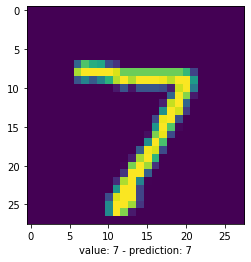

In [10]:
img = 0
x, y = next(iter(testing)) # x.shape (64, 28, 28, 1) -- 64 images 28x28 with 1 channel
recostruction(model, x, y, img)

In [11]:
def show_network(x, y, img):
    #----------------------------------------------------- INPUT

    show_prediction(x[img], y[img]) # show prediction

    #-------------------------------------------------------- CONV1

    # filters
    f = model.layers[0].get_weights()[0] # f.shape: (9, 9, 1, 256)
    # biases
    b = model.layers[0].get_weights()[1] # b.shape: (256,)
    
    #this is fixed
    #show_grid(f[:,:,0,:], 16, 16, "Conv1 256 filters") # show filters
    
    show_conv1_rfm(x, f, b, img) # show reconstructed feature maps

    #-------------------------------------------------------- OUTPUT

    x = model.convolution(x) # o.shape: (64, 20, 20, 256)
    #show_grid(x[img,:,:,:], 16, 16) # show feature maps

    #-------------------------------------------------------- PRIMARY CAPSULE

    f = model.layers[1].get_weights()[0] # f.shape: (9, 9, 256, 256)
    b = model.layers[1].get_weights()[1] # b.shape: (256,)

    #this is fixed
    #show_grid(f[:,:,:,0], 16, 16, "Primary Capsule Filter 9x9x256 #1 of 32*8") # first filter 9x9x256
    
    show_prim_caps_rfm(x, f, b, img) # shows recostructed feature maps

    #-------------------------------------------------------- OUTPUT

    x = model.primary_capsule(x) # x.shape: (64, 6, 6, 256)
    #show_grid(x[img, :, :, :], 16, 16) # feature maps of image index 0


In [12]:
def show_fixed_network_params():
    f = model.layers[0].get_weights()[0] # f.shape: (9, 9, 1, 256)
    show_grid(f[:,:,0,:], 16, 16, "Conv1 256 filters") # show filters
    
    f = model.layers[1].get_weights()[0] # f.shape: (9, 9, 256, 256)
    show_grid(f[:,:,:,0], 16, 16, "Primary Capsule Filter 9x9x256 #1 of 32*8") # first filter 9x9x256
    show_grid(f[:,:,:,0], 16, 16, "Primary Capsule Filter 9x9x256 #2 of 32*8") # first filter 9x9x256
    show_grid(f[:,:,:,0], 16, 16, "Primary Capsule Filter 9x9x256 #3 of 32*8") # first filter 9x9x256

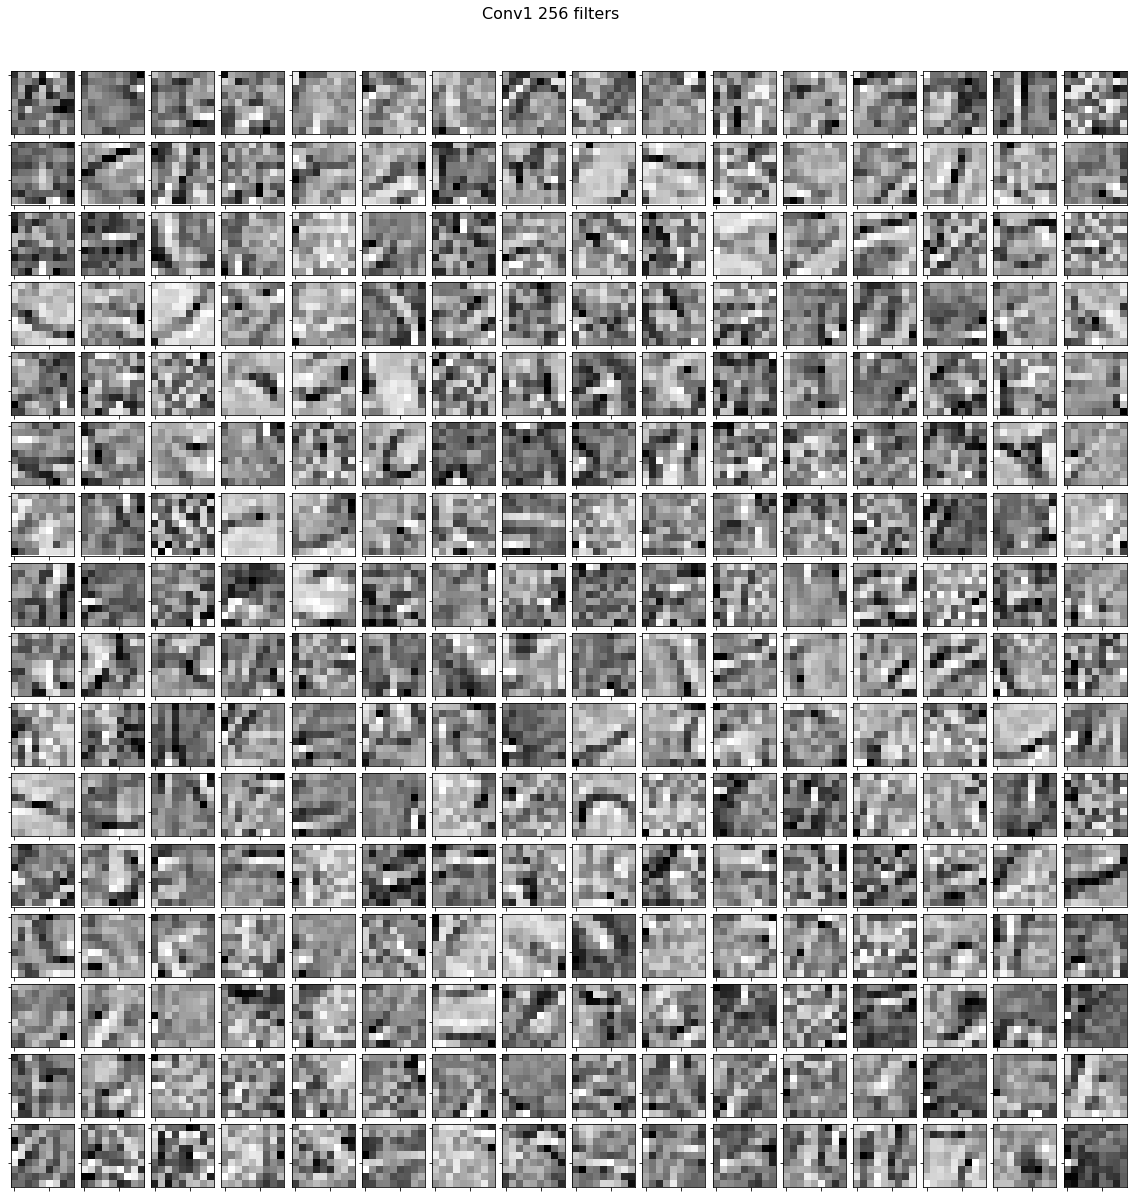

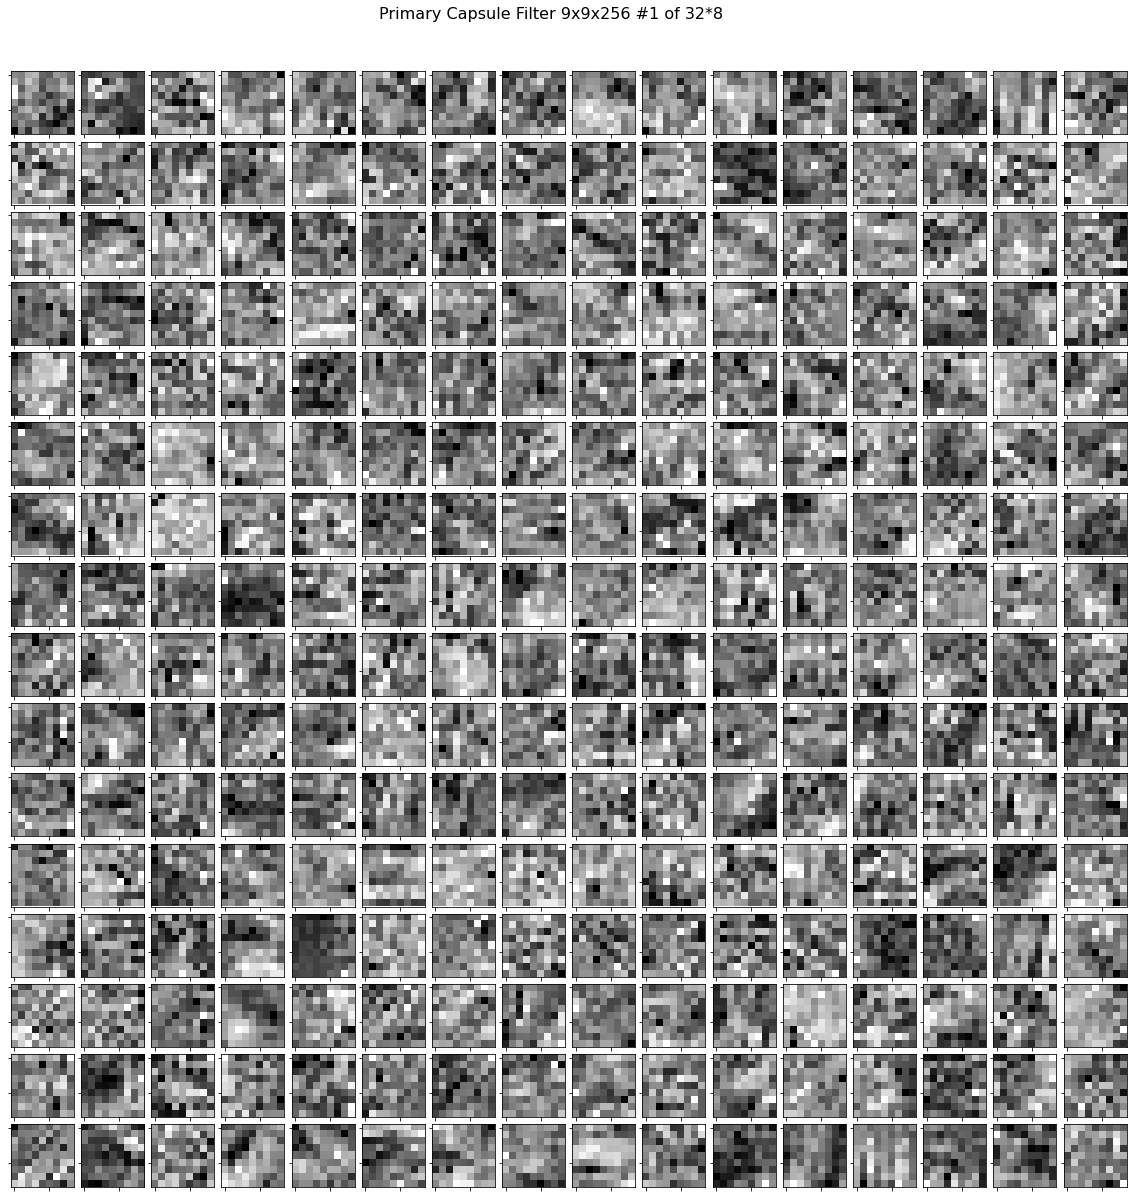

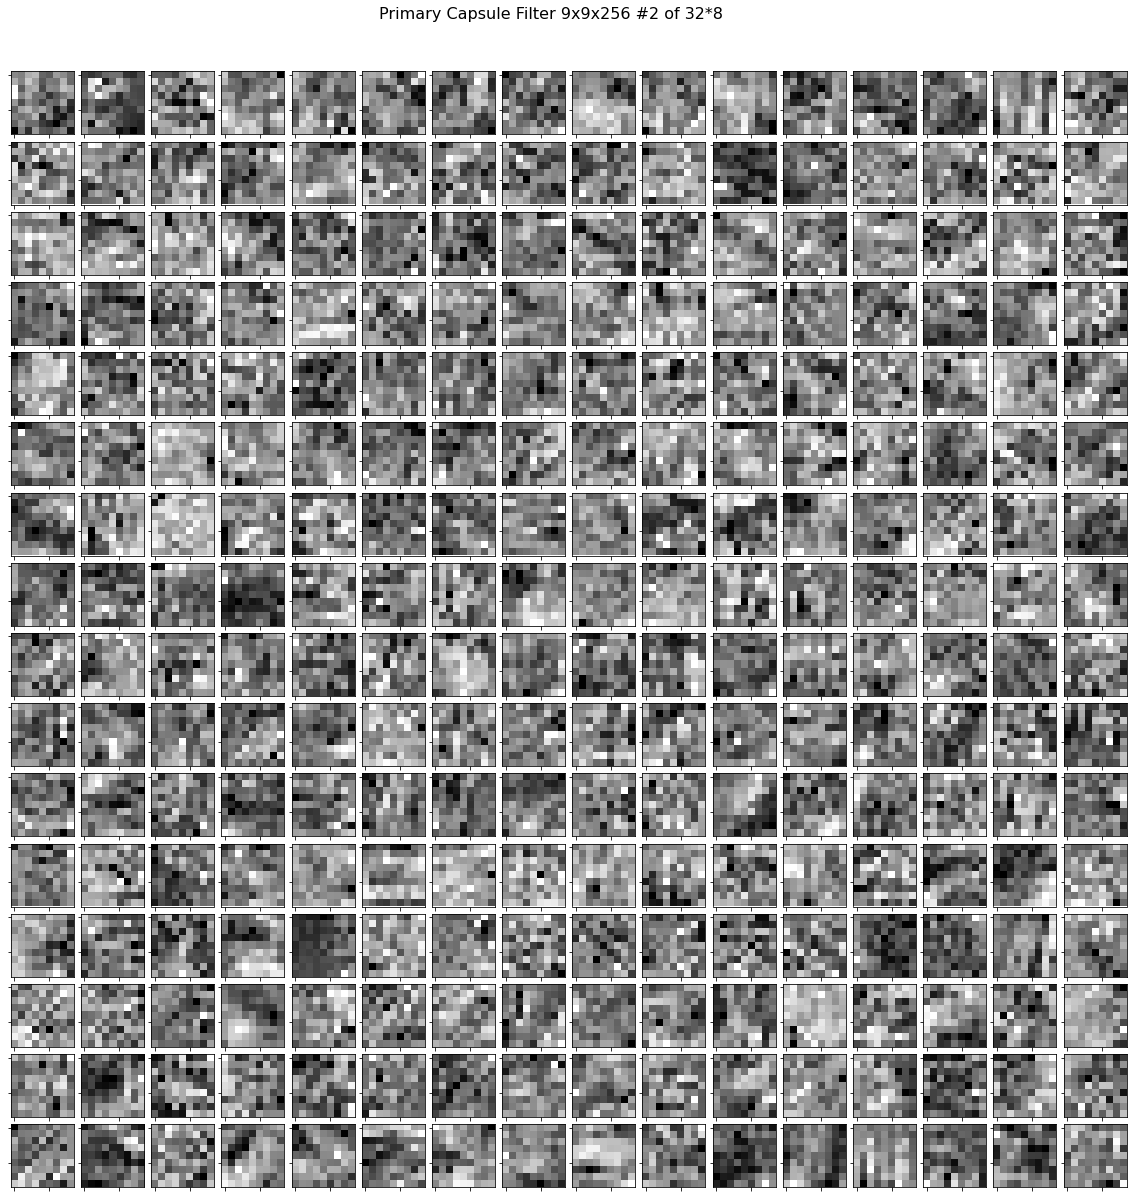

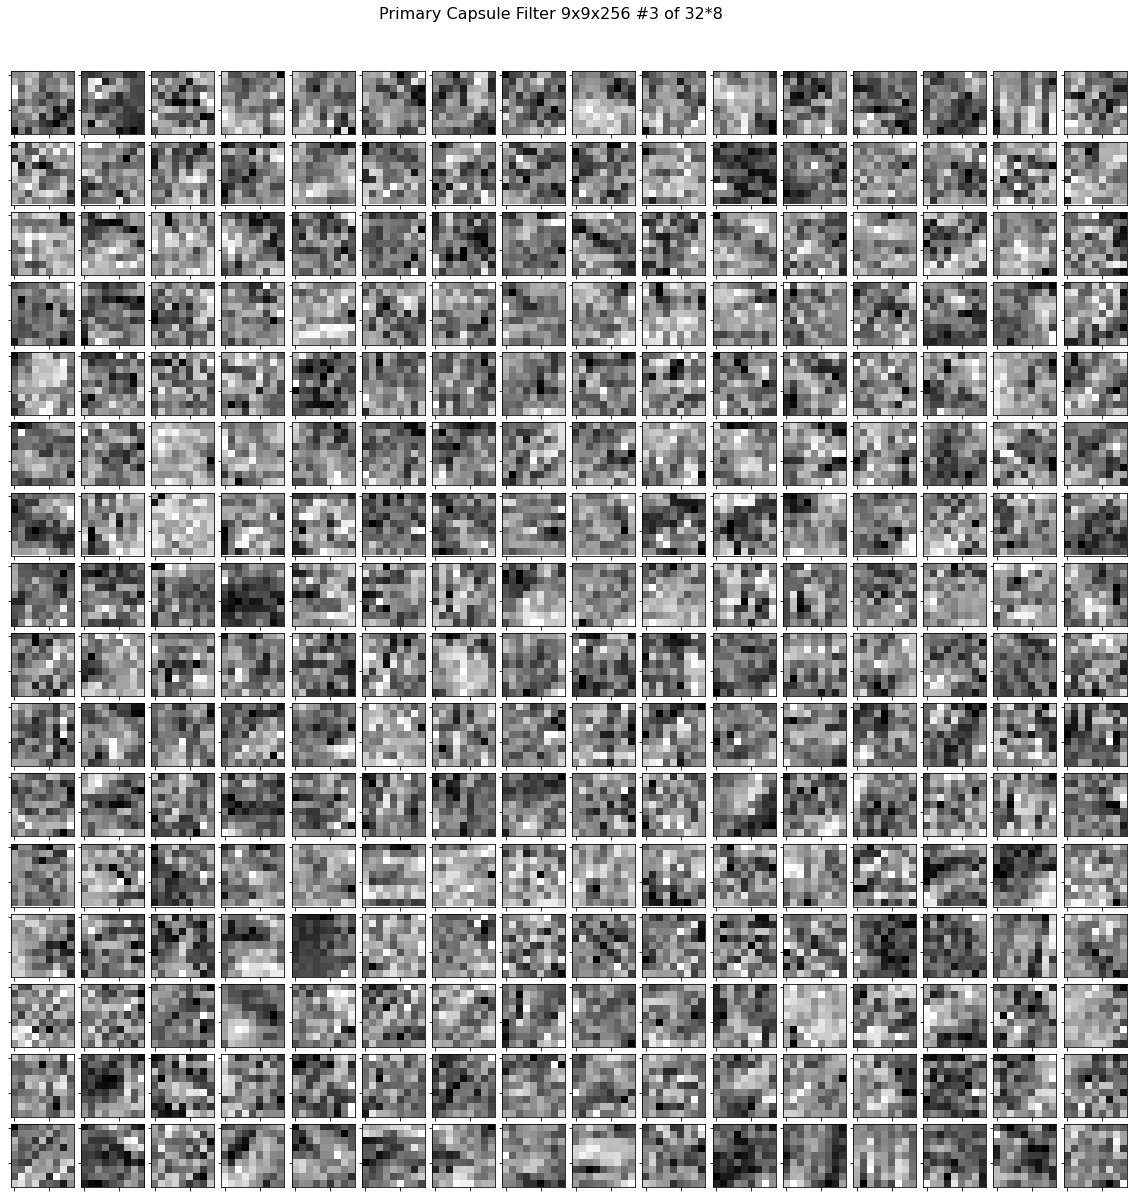

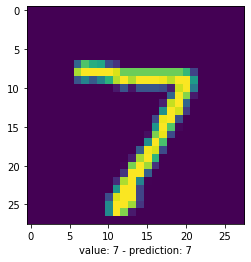

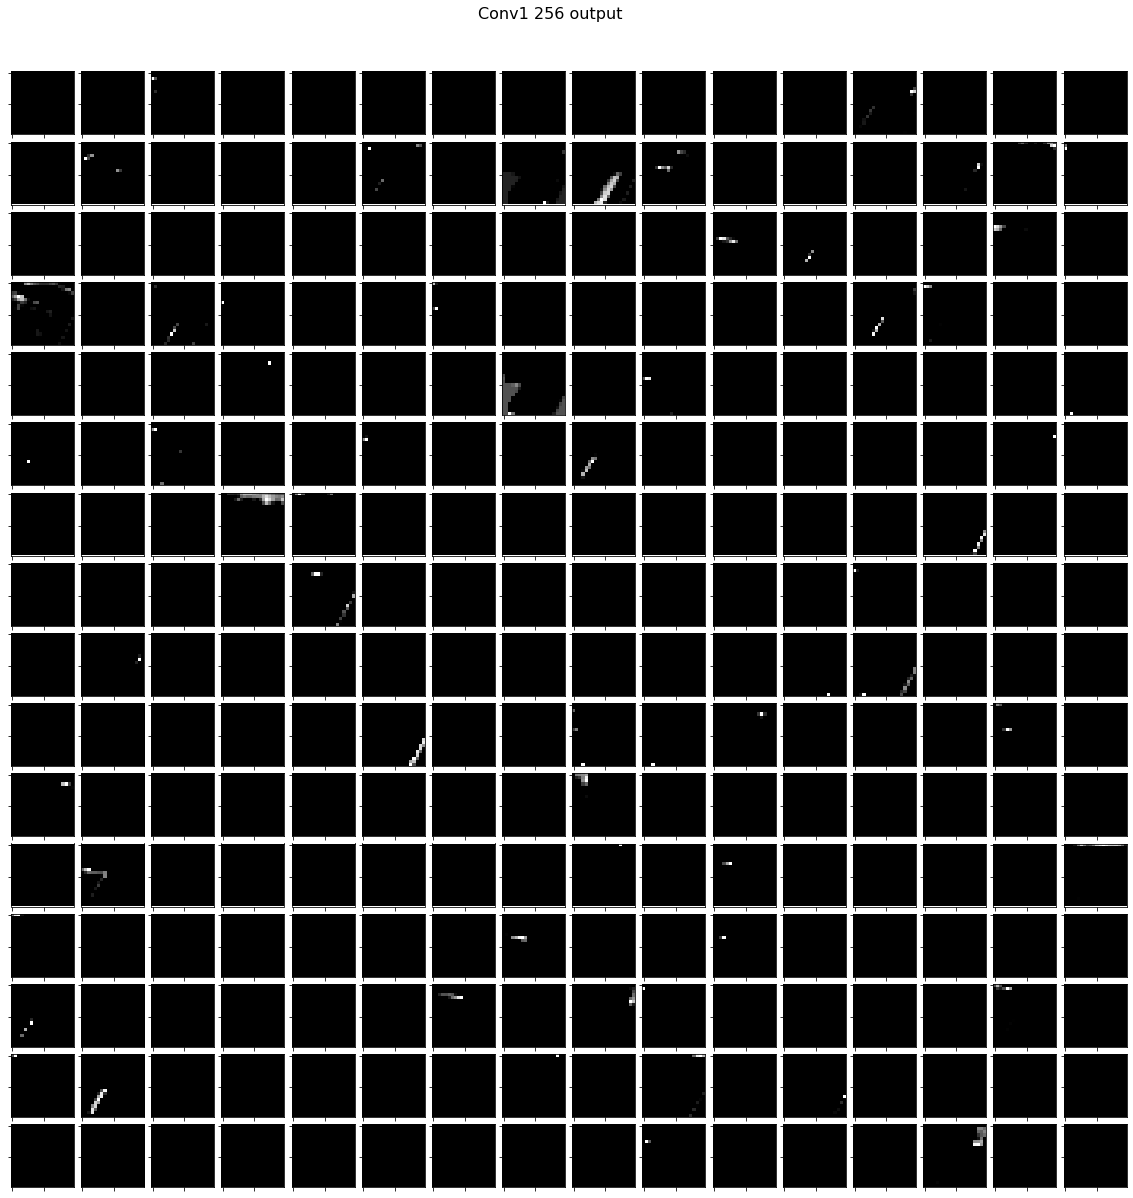

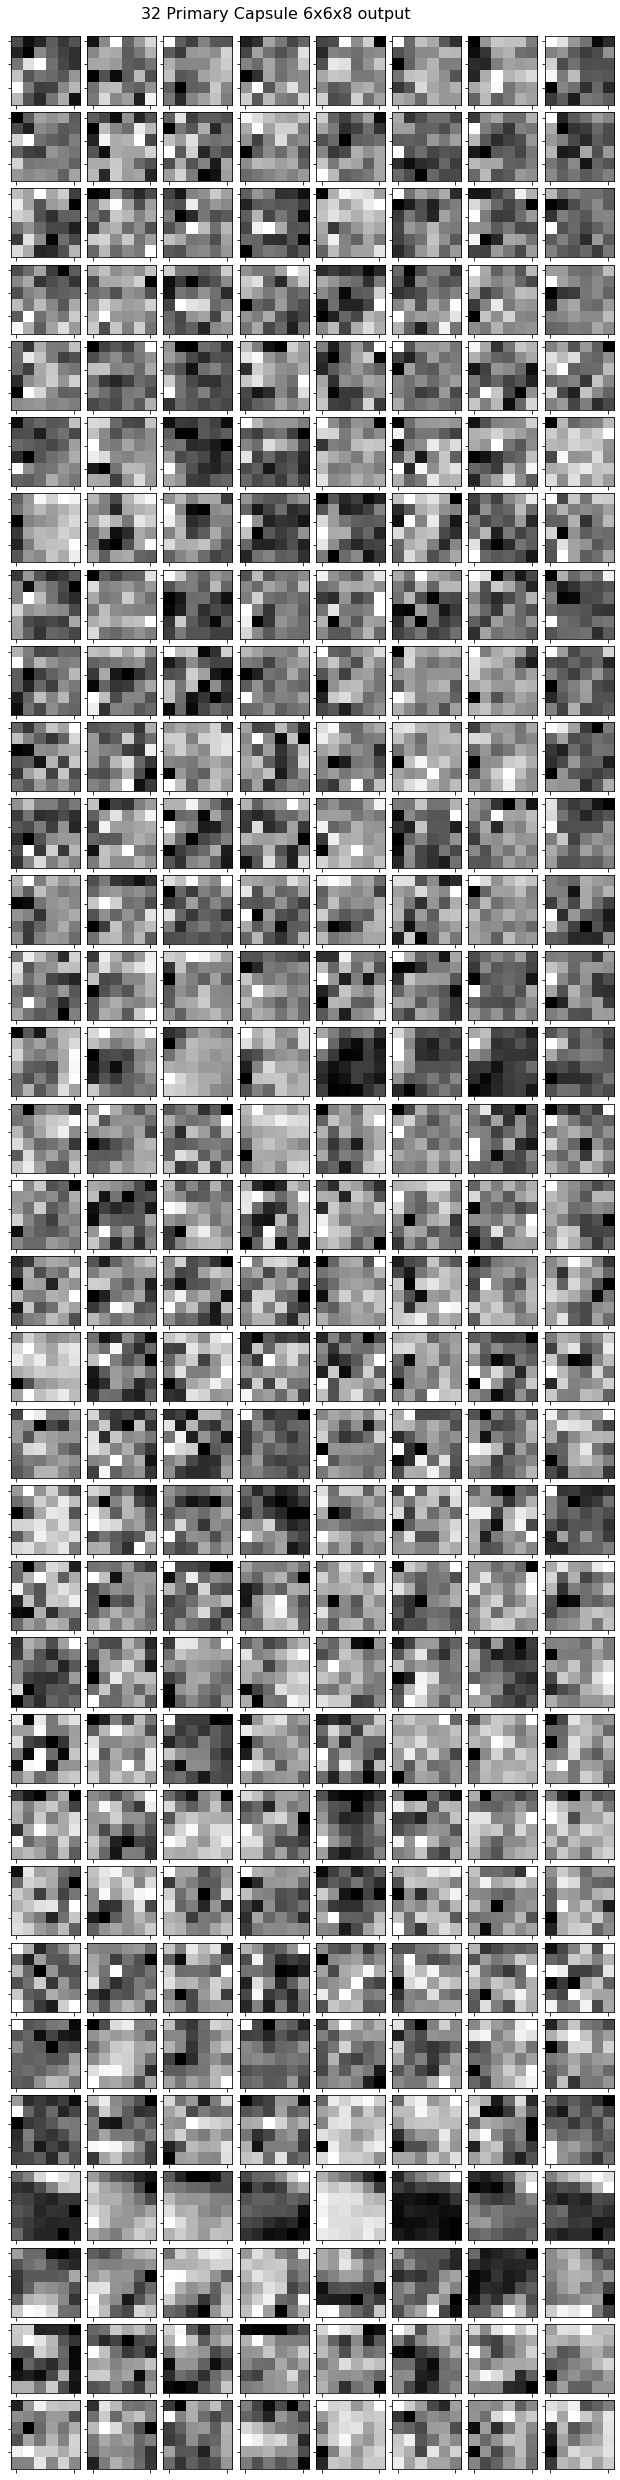

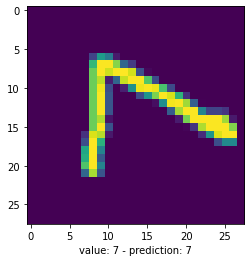

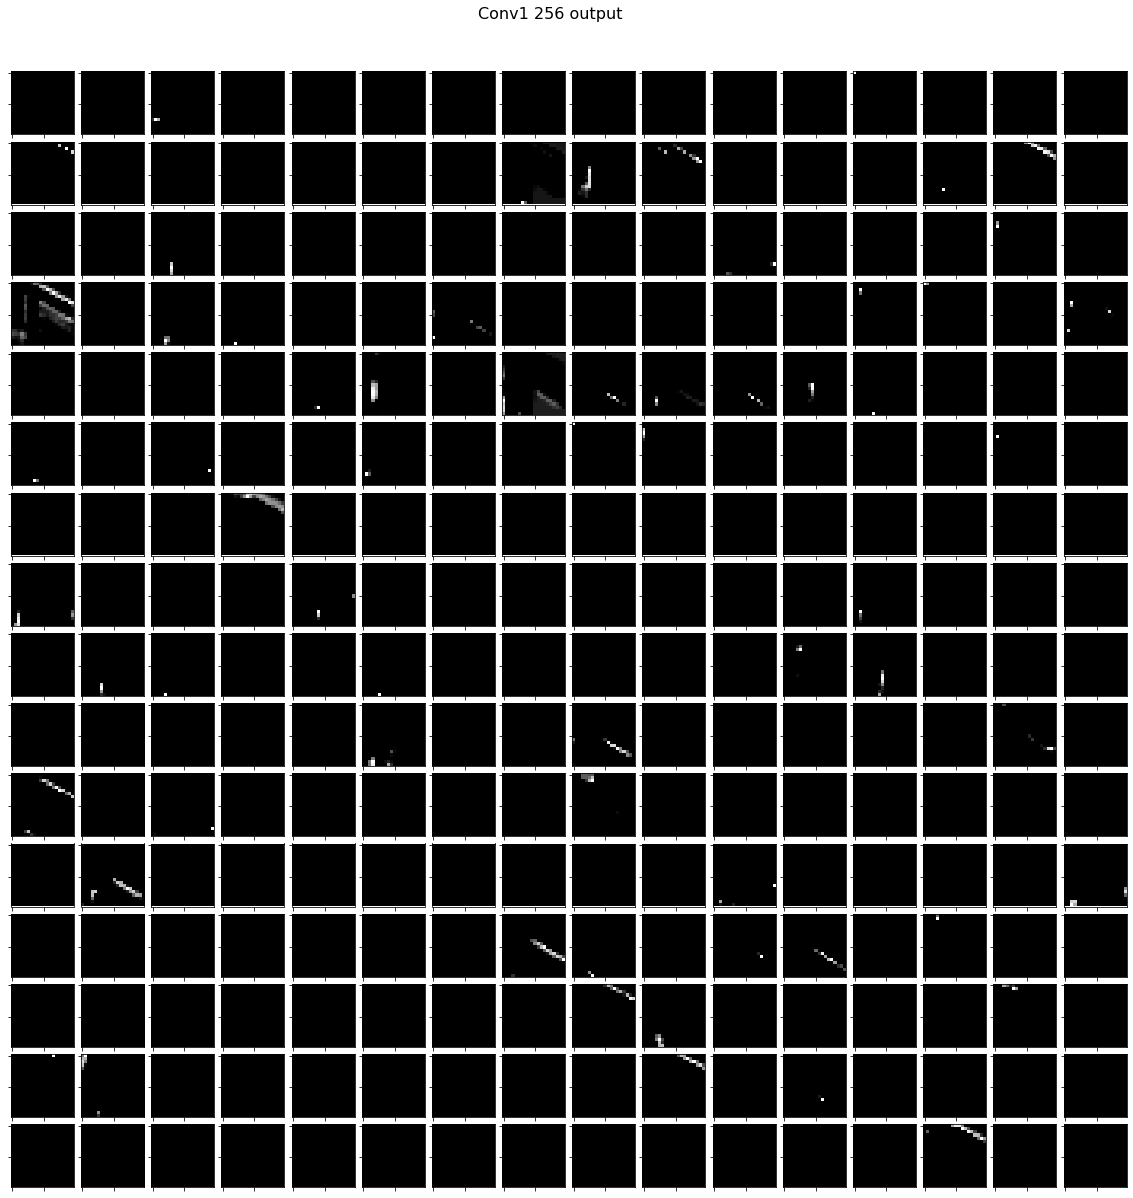

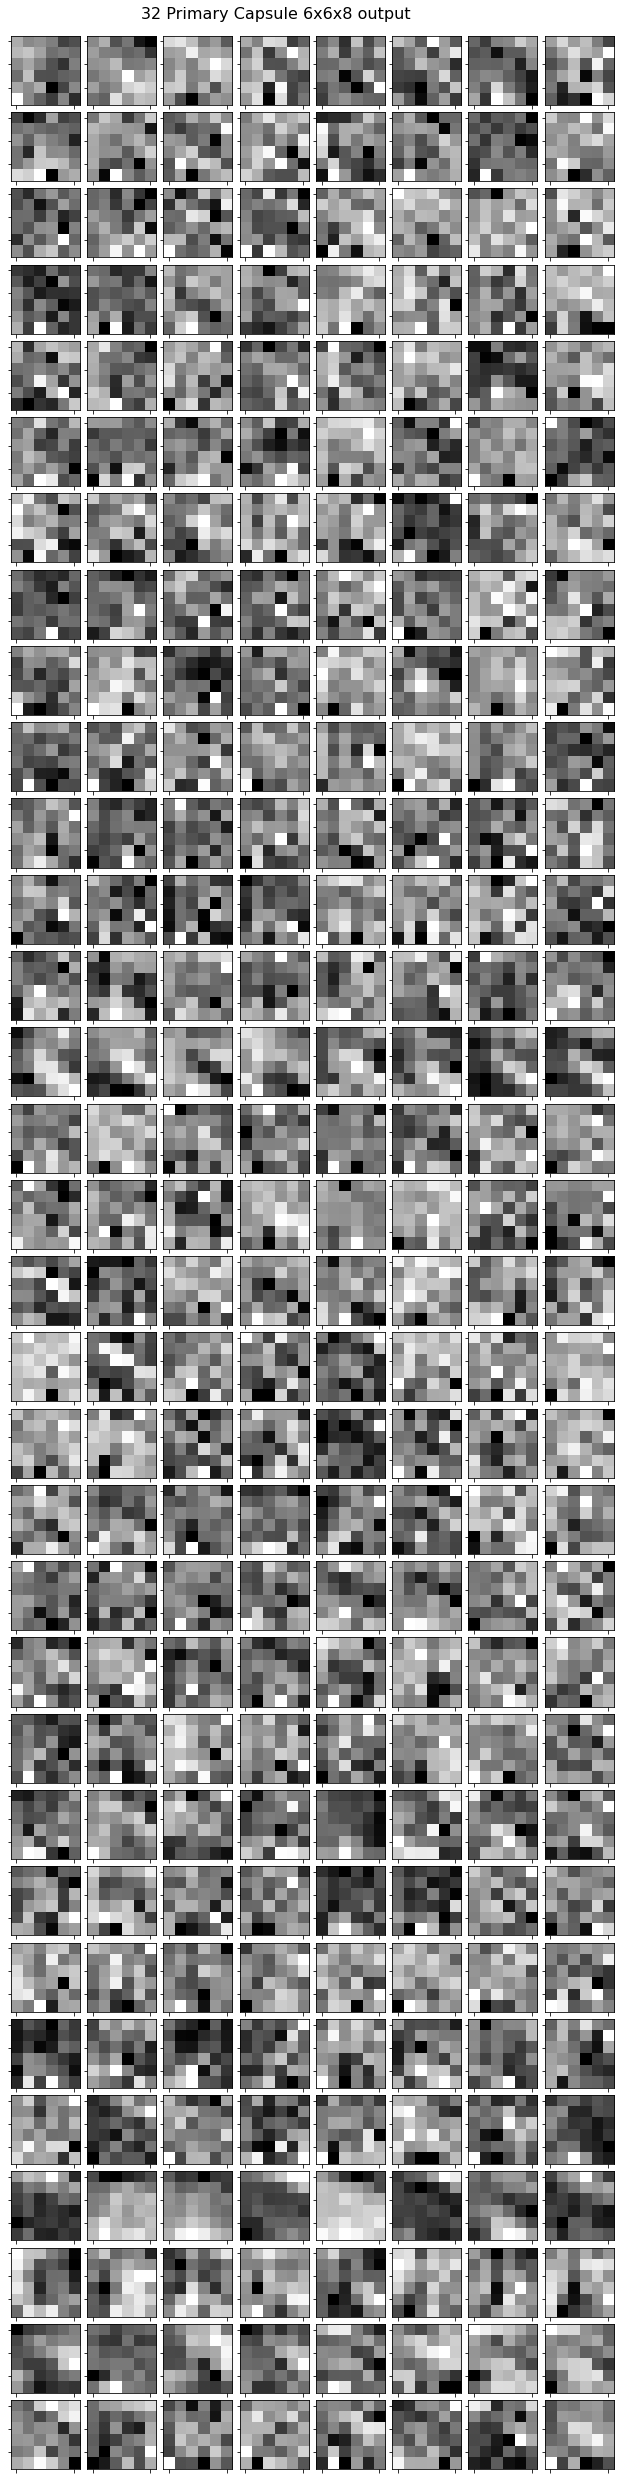

In [13]:
img = 0

show_fixed_network_params()

#----------------------------------------------------- INPUT

x, y = next(iter(testing)) # x.shape (64, 28, 28, 1) -- 64 images 28x28 with 1 channel
tx = tf.image.rot90(x)

show_network(x, y, img)
show_network(tx, y, img)